In [1]:
import numpy as np
from scipy import signal
import random
import cmath
import librosa
import IPython.display as ipd

In [2]:
#get omega, sigma, K
def getsigma(m1,m2,alpha,p,s11):        
    beta = alpha + 1/alpha
    sigma = s11 * (1 + p * ((m1**2 * alpha + m2**2/alpha) - beta))
    return sigma

def getomega(m1,m2,alpha,p,D,w11,s11):
    interm = m1**2 * alpha + m2**2/alpha
    beta = alpha + 1/alpha
    omega_sq = D**2 * w11**2 * interm**2 + interm * (s11**2 * (1 - p * beta)**2/beta + w11**2 * (1 - D**2 * beta**2)/beta) - s11**2 * (1 - p * beta)**2
  
    return np.sqrt(omega_sq)
    

def getk(m1,m2,omega,f1,f2):
    k = f1 * f2 * np.sin(m1 * np.pi/2) * np.sin(m2 * np.pi/2)/omega #assuming x1,x2 at center of the surface
    #print(np.sum(k))
    return k

#calculate integral and approximate excitation function with gaussian distribution
def getf(m,l,tau):
    #trapezoid rule to integrate f(x)sin(mpix) from 0 to l
    #(f(a)+f(b))*(b-a)/2
    integral = 0
    x = approxnorm(l,l/2,0.4,tau)
    h = l/tau
    for i in range(tau):
        #x(i+2)
        #print(x.shape,x[0],x[0,1])
        integral = integral + (x[i] * np.sin(m * np.pi * i * h/l) + x[i+1] * np.sin(m * np.pi * (i + 1) * h/l))*h/2
    integral = integral*2/l
    return integral

def approxnorm(l,mu,s,tau):
    h = l/tau
    #x = np.zeros((1,tau + 1))
    x = []
    for i in range(tau+1):
        #x[i] = 1/(s * np.sqrt(2*np.pi)) * np.exp(-0.5 * (i * h - mu)**2/s**2)
        x.append(1/(s * np.sqrt(2*np.pi)) * np.exp(-0.5 * (i * h - mu)**2/s**2))
    return x



Delta excitation at (x,y,t)

In [3]:
def get_del_k(m1,m2,omega,x1,x2,l,alpha):
    l2 = l * alpha
    k = 4/(l * l2) * (np.sin(m1 * np.pi * x1/l))**2 * (np.sin(m2 * np.pi * x2/l2))**2 / omega #assuming x1,x2 at center of the surface
    print(k)
    return k

## parameters/pre-calculations

In [4]:
w11=200 * 2 * np.pi#range 200hz-1200hz
tau11 = 0.2#range 0.01-0.3
s11 = -1/tau11
p = 0.3 #how round the sound is, smaller the rougher(metal), range 0-0.3
D = 0 #inharmonicity in smaller values, range 0-10
alpha = 1 #range 0-5
m1 = 5
m2 = 5
l = np.pi
#def surfacemodel(w11,tau11,p,D,alpha,m1,m2):
    

sigma=np.zeros((m1,m2))
omega=np.zeros((m1,m2))
k=np.zeros((m1,m2))

x1 = 1
x2 = l*alpha/2


for i in range(m1):
    for j in range(m2):
        sigma[i,j] = getsigma(i+1,j+1,alpha,p,s11)
        omega[i,j] = getomega(i+1,j+1,alpha,p, D,w11,s11)
        k[i,j] = getk(i+1,j+1,omega[i,j],getf(i+1,1,300),getf(j+1,alpha,300))
        #k[i,j] = get_del_k(i+1,j+1,omega[i,j],x1,x2,l,alpha)


In [122]:
print(np.sum(k))

0.0008955482452133814


## impulse implementation

In [7]:
import soundfile as sf

In [10]:
sr = 44100
dur = sr*2

import time
start_time = time.time()

y = []
for t in range(dur):
    #y[0,t] = np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr)))
    y.append(np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr))))
    #y.append(np.sum(np.sum(np.exp(sigma * t/sr) * np.sin(omega * t/sr) / omega)))
    
#y2 = y/np.max(np.abs(np.array(y)))
y2 = y
print("--- %s seconds ---" % (time.time() - start_time))
ipd.Audio(y2,rate = sr)

--- 2.111013889312744 seconds ---


In [9]:

sf.write('drum_strike2.wav',y2,sr)


## difference implementation

In [11]:
## impulse invariant implementation revised (according to z transform table)
sr = 44100

y_1 = 0.0
y_2 = 0.0
x_1 = 0.0

#alternative excitation
#N = 10
#x=[0 for i in range(int(2*sr))]
#for i in range(N):
#    if i<=N:
#        x[i]=random.randint((-2)**15,2**15)/2**15
#    else:
#        x[i]=0.0



        
import time
start_time = time.time()
x_0 = 1
y_iii = []
for n in range(sr*2):
    #each sigma, omega corresponds to a matrix of modes, thus when updating need a matrix of y values
    ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(2*sigma/sr)*y_2+np.exp(sigma/sr)/omega*np.sin(omega/sr)*x_1 #with impulse
    #ytemp = 2*np.exp(sigma)*np.cos(omega)*y_1-np.exp(sigma)*y_2-x_0/omega+np.exp(sigma)/omega*np.cos(omega)*x_1 
    #ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(sigma/sr)*y_2-x[n]*k+np.exp(sigma/sr)*np.cos(omega/sr)*k*x_1 #with excitation
    #print(y_1)
  
    #print(np.sum(np.sum(ytemp)))
    
    y_iii.append(np.sum(np.sum(ytemp)))
    x_1 = x_0
    x_0 = 0.0
    y_2 = y_1
    y_1 = ytemp
print("--- %s seconds ---" % (time.time() - start_time))
ipd.Audio(y_iii,rate=sr)

--- 3.4720571041107178 seconds ---


In [12]:
## impulse invariant implementation (according to hand calculation)
sr = 44100

y_1 = 0.0
y_2 = 0.0
x_1 = 0.0

#alternative excitation
#N = 10
#x=[0 for i in range(int(2*sr))]
#for i in range(N):
#    if i<=N:
#        x[i]=random.randint((-2)**15,2**15)/2**15
#    else:
#        x[i]=0.0



        
import time
start_time = time.time()
x_0 = 1
y_iih = []
for n in range(sr*2):
    #each sigma, omega corresponds to a matrix of modes, thus when updating need a matrix of y values
    ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(2*sigma/sr)*y_2-x_0/omega+np.exp(sigma/sr)/omega*np.cos(omega/sr)*x_1 #with impulse
    #ytemp = 2*np.exp(sigma)*np.cos(omega)*y_1-np.exp(sigma)*y_2-x_0/omega+np.exp(sigma)/omega*np.cos(omega)*x_1 
    #ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(sigma/sr)*y_2-x[n]*k+np.exp(sigma/sr)*np.cos(omega/sr)*k*x_1 #with excitation
    #print(y_1)
    
    #print(np.sum(np.sum(ytemp)))
    
    y_iih.append(np.sum(np.sum(ytemp)))
    x_1 = x_0
    x_0 = 0.0
    y_2 = y_1
    y_1 = ytemp
print("--- %s seconds ---" % (time.time() - start_time))
ipd.Audio(y_iih,rate=sr)

--- 3.5546770095825195 seconds ---


In [7]:
## bilinear transform implementation


y_1 = 0.0
y_2 = 0.0
x_1 = 0.0
x_2 = 0.0
sr=44100
        
import time
start_time = time.time()
x_0 = 1
y_bt = []
for n in range(sr*2):
    #each sigma, omega corresponds to a matrix of modes, thus when updating need a matrix of y values
    #ytemp = 2*np.exp(sigma/sr)*np.cos(omega/sr)*y_1-np.exp(sigma/sr)*y_2-x_0/omega+np.exp(sigma/sr)/omega*np.cos(omega/sr)*x_1 #with impulse
    ytemp = 1/(1-sigma+omega**2)*(x_0+2*x_1+x_2-(2*omega**2+2*sigma**2-2)*y_1-((sigma+1)**2+omega**2)*y_2)
    
    
    y_bt.append(np.sum(np.sum(ytemp)))
    x_2 = x_1
    x_1 = x_0
    x_0 = 0.0
    y_2 = y_1
    y_1 = ytemp
print("--- %s seconds ---" % (time.time() - start_time))
ipd.Audio(y_bt,rate=44100)

/Users/lilyh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: overflow encountered in multiply
/Users/lilyh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


--- 3.0118210315704346 seconds ---


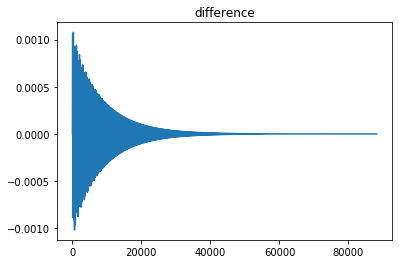

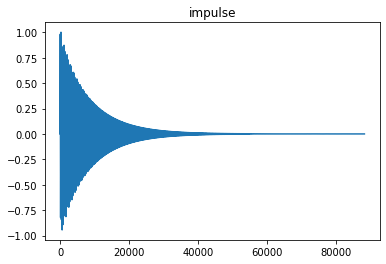

In [92]:
import matplotlib.pyplot as plt
plt.plot(range(len(y)),y)
plt.title('difference')
plt.figure(2)
plt.plot(range(len(y2)),y2)
plt.title('impulse')
plt.show()

## real time implementation

demo

In [4]:
# synthesize sound of a guitar string, create a random sinusoid signal, filter it and play

import struct
import wave
from matplotlib import pyplot
import numpy as np
import pyaudio
from scipy import signal
import random
import math
# Specify wave file

# Open wave file

# Read wave file properties
RATE        = 8000     # Frame rate (frames/second)
WIDTH       = 2     # Number of bytes per sample
CHANNELS    = 1      # Number of channels

print('The file has %d channel(s).'         % CHANNELS)
print('The file has %d frames/second.'      % RATE)
print('The file has %d bytes per sample.'   % WIDTH)

p = pyaudio.PyAudio()

stream = p.open(
    format =  pyaudio.paInt16,
    channels = CHANNELS,
    rate = RATE,
    input = False,
    output = True)


#Karplus-Strong parameters
K=0.99
N=60
#Time duration
DURATION=2.0
K2 = int( DURATION * RATE )   # Number of blocks

x=[0 for i in range(int(DURATION*RATE))]

for i in range(N):
    if i<=N:
        x[i]=random.randint(-2**15,2**15)
    else:
        x[i]=0.0

x=np.array(x)

#print(x)

# Create a buffer (delay line) for past values
BUFFER_LEN =  N+2                          # Buffer length
buffer = [0.0 for i in range(BUFFER_LEN)]   # Initialize to zero

# Buffer (delay line) indices

# print('The delay of {0:.3f} seconds is {1:d} samples.'.format(delay_sec, delay_samples))
print('The buffer is {0:d} samples long.'.format(BUFFER_LEN))
kr=0
kw=0

for i in range(K2):

    input_value=x[i]
    
    if kr+1==BUFFER_LEN:
        output_value = input_value+ K/2*(buffer[kr]+buffer[0])  # use int() for integer
        kr=0
    else:
        output_value = input_value+ K/2*(buffer[kr]+buffer[kr+1])  # use int() for integer
        kr+=1

    # Update buffer (pure delay)
    buffer[kw]=output_value
   
    output_string = struct.pack('h', int(output_value))  
    if kw+1==BUFFER_LEN:
        kw=0
    else:
        kw=kw+1
    stream.write(output_string)  


stream.stop_stream()
stream.close()
p.terminate()

The file has 1 channel(s).
The file has 8000 frames/second.
The file has 2 bytes per sample.
The buffer is 62 samples long.


real

## Impulse implementation (x1,x2) -> sounds

In [22]:
def hitdiffparts(r1,r2):
    
    w11=200 * 2 * np.pi#range 200hz-1200hz
    tau11 = 0.2#range 0.01-0.3
    s11 = -1/tau11
    p = 0.3 #how round the sound is, smaller the rougher(metal), range 0-0.3
    D = 0 #inharmonicity in smaller values, range 0-10
    alpha = 1 #range 0-5
    m1 = 5
    m2 = 5
    l = np.pi
    l2 = l * alpha
    
    x1 = l*r1
    x2 = l2*r2
    
    sigma=np.zeros((m1,m2))
    omega=np.zeros((m1,m2))
    k=np.zeros((m1,m2))

    for i in range(m1):
        for j in range(m2):
            sigma[i,j] = getsigma(i+1,j+1,alpha,p,s11)
            omega[i,j] = getomega(i+1,j+1,alpha,p, D,w11,s11)
            #k[i,j] = getk(i+1,j+1,omega[i,j],getf(i+1,1,300),getf(j+1,alpha,300))
            k[i,j] = get_del_k(i+1,j+1,omega[i,j],x1,x2,l,alpha)
    
    sr = 44100
    dur = sr*2
    start_time = time.time()

    y = []
    for t in range(dur):
        #y[0,t] = np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr)))
        y.append(np.sum(np.sum(k * np.exp(sigma * t/sr) * np.sin(omega * t/sr))))
        #y.append(np.sum(np.sum(np.exp(sigma * t/sr) * np.sin(omega * t/sr) / omega)))
    
    y2 = y/np.max(np.abs(np.array(y)))
    
    print("--- %s seconds ---" % (time.time() - start_time))
    ipd.Audio(y2,rate=sr)
    return y2

In [23]:
#### x1 = l/2, x2 = l2/2 ####

y1 = hitdiffparts(0.5,0.5)
ipd.Audio(y1,rate=sr)

--- 1.8679156303405762 seconds ---


In [24]:
y1 = hitdiffparts(0.2,0.8)
ipd.Audio(y1,rate=sr)

--- 2.019075870513916 seconds ---


In [27]:

sf.write('drum_hit_1_9.wav',y1,sr)

In [26]:
y1 = hitdiffparts(0.1,0.9)
ipd.Audio(y1,rate=sr)

--- 2.0529048442840576 seconds ---


In [48]:
y1 = hitdiffparts(0.3,0.3)
ipd.Audio(y1,rate=sr)

--- 2.3832180500030518 seconds ---


In [6]:
import hitdifferentparts
import IPython.display as ipd
sr = 44100
dur = sr*2

In [8]:
y1 = hitdifferentparts.hitdiffparts(0.1,0.9)
ipd.Audio(y1,rate=sr)

--- 1.882674217224121 seconds ---
